In [491]:
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets
import pandas as pd
import numpy as np
import roc_auc
import estimator_knn as knn
import estimator_rssibased as rssie
import json

In [233]:
# data loader
ds = datasets.load('data/raw/0[12]_[01][123]_0[1234]*_*')

path = data/raw/0[12]_[01][123]_0[1234]*_*
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅
...x..........................
data/raw/01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅
.........................x....
data/raw/01_01_04_4F実験室_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅
.....................x........
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
..............................
data/raw/01_02_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ外出
..............................
data/raw/01_02_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ外出
..............................
data/raw/01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅
..............................
data/raw/01_03_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅
..............................
data/raw/01_03_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅
..............................
data/raw/01_11_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/01_11_02_エネマネハウス_XperiaZ3_カバン_裏上_正常_まっす

In [ ]:
def knn_combinations

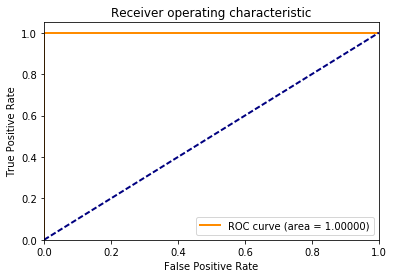

auc 1.00000


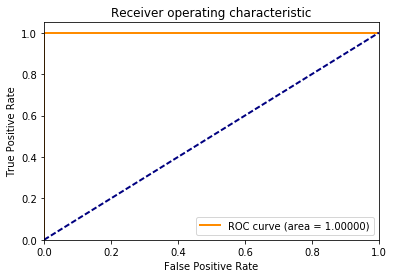

auc 1.00000


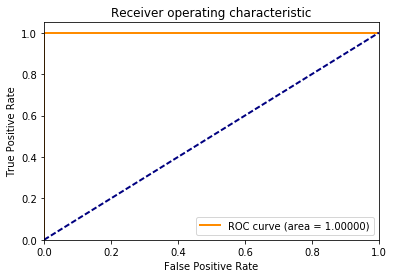

auc 1.00000


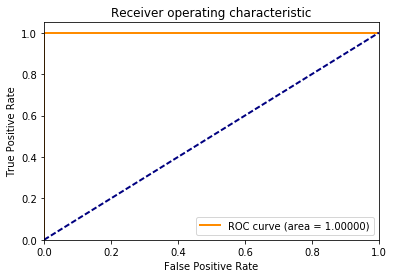

auc 1.00000


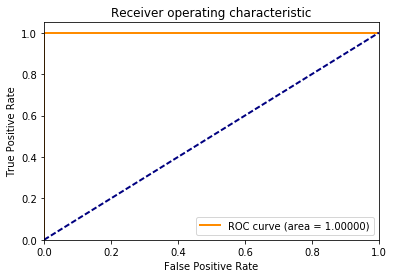

auc 1.00000


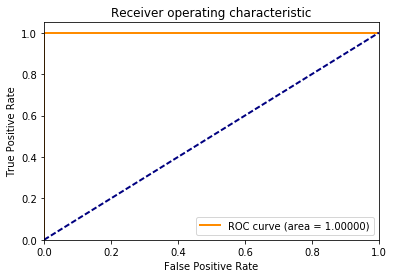

auc 1.00000


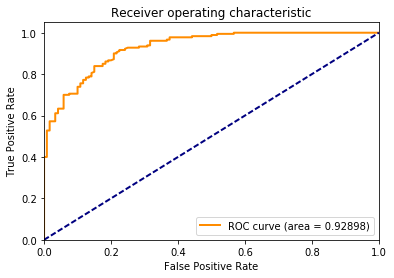

auc 0.92898


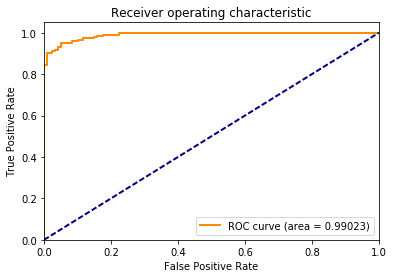

auc 0.99023


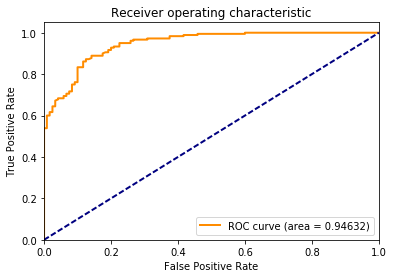

auc 0.94632


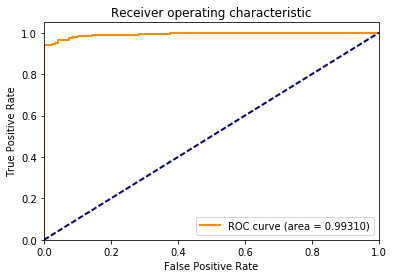

auc 0.99310


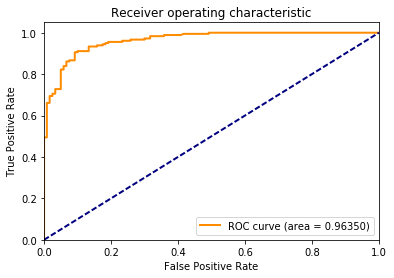

auc 0.96350


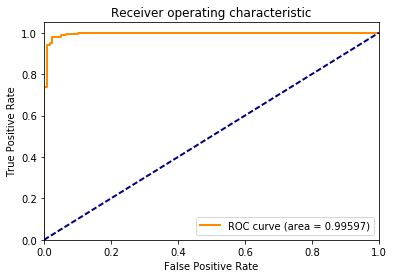

auc 0.99597


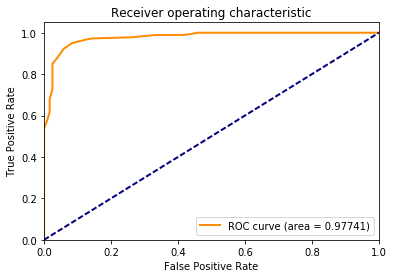

auc 0.97741


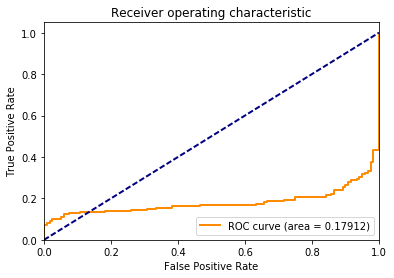

auc 0.17912


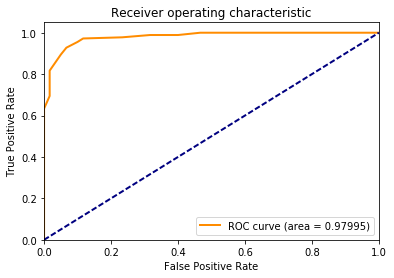

auc 0.97995


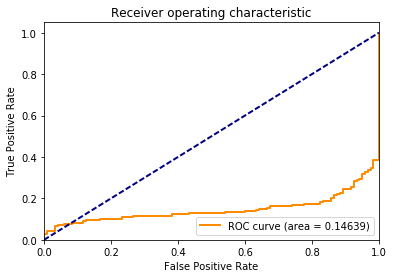

auc 0.14639


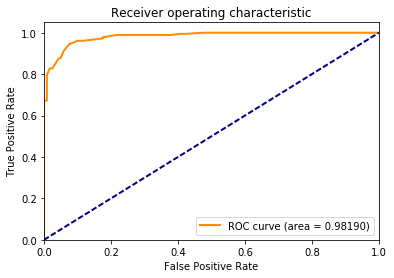

auc 0.98190


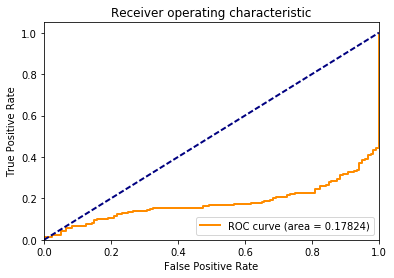

auc 0.17824


,algorithm,ma_window,model_idx,ms_interval,n_neighbors,n_record,n_train,sensor_type,type,auc
0,ball_tree,1,0,20,1.0,1,1,"[rssi.a, rssi.b]",kNN,1.000000
1,ball_tree,1,0,20,1.0,1,1,"[[linear_accel[0], linear_accel[1], linear_acc...",kNN,1.000000
2,ball_tree,1,0,40,1.0,1,1,"[rssi.a, rssi.b]",kNN,1.000000
3,ball_tree,1,0,40,1.0,1,1,"[[linear_accel[0], linear_accel[1], linear_acc...",kNN,1.000000
4,ball_tree,1,0,100,1.0,1,1,"[rssi.a, rssi.b]",kNN,1.000000
5,ball_tree,1,0,100,1.0,1,1,"[[linear_accel[0], linear_accel[1], linear_acc...",kNN,1.000000
6,ball_tree,1,1,20,3.0,1,1,"[rssi.a, rssi.b]",kNN,0.928981
7,ball_tree,1,1,20,3.0,1,1,"[[linear_accel[0], linear_accel[1], linear_acc...",kNN,0.990231
8,ball_tree,1,1,40,3.0,1,1,"[rssi.a, rssi.b]",kNN,0.946319
9,ball_tree,1,1,40,3.0,1,1,"[[linear_accel[0], linear_accel[1], linear_acc...",kNN,0.993102


In [506]:
# grid search implementation (under test)
def test():
    # knn parameters
    range_n_neighbors = np.arange(1, 5, 2)
    
    # create estimator list
    models = []
    mesh_data = np.meshgrid(range_n_neighbors)
    for n_neighbors, in zip(mesh_data[0].ravel()):
        models.append(knn.EstimatorKNN(n_neighbors=n_neighbors))
    models.append(rssie.EstimatorRssiBased())
    
    # other  parameters
    sensor_type_master = [
        ['rssi.a', 'rssi.b'],
        [['linear_accel[0]', 'linear_accel[1]', 'linear_accel[2]']]
    ]
    range_n_record = np.arange(1, 10, 10)
    range_n_train = np.arange(1, 20, 20)
    range_ms_interval = np.array([20, 40, 100])
    range_ma_window = np.arange(1, 4, 4)
    range_sensor_type = sensor_type_master # to be combinationable
    
    mesh_data = np.meshgrid(range(len(models)), range_n_record, range_n_train,
                            range_ms_interval, range_ma_window, range_sensor_type)

    # create grid test case
    test_case = []
    for model_idx, n_record, n_train, ms_interval, ma_window, sensor_type in zip(mesh_data[0].ravel(), mesh_data[1].ravel(), mesh_data[2].ravel(),
               mesh_data[3].ravel(), mesh_data[4].ravel(), mesh_data[5].ravel()):
        model = models[model_idx]
                            
        # save test case and result
        _t = {'model_idx': model_idx, 'n_record': n_record, 'n_train': n_train,
              'ms_interval': ms_interval, 'ma_window': ma_window, 'sensor_type': sensor_type}
        _t.update(model.get_params())
        _t['type'] = model.get_type()
        test_case.append(_t)
    
    # remove unavailable test case
    df = pd.DataFrame(test_case)
    #df = df[~((df.neighbor == 3) & (df['sample'] == 10))]
    
    # limit test case for test
    #df = df[:2]
    
    # set the data title
    base = '01_11_01'
    normal = '^01_11'
    anomaly = '^01_1[23]'
    
    # run test
    auc_list = []
    for k, t in df.iterrows():
        auc = eval_estimator(models[t['model_idx']], base=base, normal=normal, anomaly=anomaly,
                             n_train=t['n_train'], sensor_type=t['sensor_type'], n_record=t['n_record'],
                             ms_interval=t['ms_interval'], ma_window=t['ma_window'])
        auc_list.append(auc)
    
    df['auc'] = auc_list

    # output as csv
    df.to_csv('test_record.csv')
    
    return df

test()

In [453]:
def read_csv():
    f = lambda x : json.loads(x.replace("'","\""))
    df = pd.read_csv('test_record.csv', converters={'sensor_type': f}, index_col=0)
    return df
#read_csv()

,ma_window,ms_interval,n_neighbor,n_record,n_train,sensor_type,auc
0,1,20,1,1,1,"[rssi.a, rssi.b]",0.928981
1,1,20,1,1,1,"[[linear_accel[0], linear_accel[1], linear_acc...",0.990231


In [490]:
importlib.reload(rssie)

<module 'estimator_rssibased' from 'estimator_rssibased.ipynb'>

In [456]:
# general estimator test
def eval_estimator(
    model,
    sensor_type = ['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']],
    n_record = 3,
    base = '01_11_01',
    normal = '^01_11',
    anomaly = '^01_1[23]',
    ms_interval = 20,
    ma_window = 3,
    n_train = 3,
    normalize = True):
    
    # recalc input
    drop_interval = int(ms_interval / 20)
    
    # get data
    dfl_b = datasets.get_data(ds, title=base, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)[:n_train]
    dfl_n = datasets.get_data(ds, title=normal, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title=anomaly, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)

    # moving average
    dfl_b = datasets.moving_average(dfl_b, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)
    
    # normalize
    if normalize == True:
        dfl_b_n = datasets.normalize_by_base_data(dfl_b, dfl_b, sensor_type)
        dfl_n_n = datasets.normalize_by_base_data(dfl_b, dfl_n, sensor_type)
        dfl_o_n = datasets.normalize_by_base_data(dfl_b, dfl_o, sensor_type)

    # get numpy array
    data_2d_b = [df.as_matrix() for df in dfl_b_n]
    data_2d_n = [df.as_matrix() for df in dfl_n_n]
    data_2d_o = [df.as_matrix() for df in dfl_o_n]

    # to list of numpy.array
    data_b = [d.ravel() for d in data_2d_b]
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model.fit(data_n)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=True)
    print('auc %.5f'%(auc))
    
    return auc

#eval_estimator()